In [1]:
from datetime import datetime as dt, timedelta
import json
import sys
import time

import concurrent
from functools import partial
import multiprocessing.dummy as mp 
from multiprocessing import Pool, Manager, cpu_count, Manager , Process
from multiprocessing.pool import ThreadPool
import multiprocessing

from statistics import median, mean, stdev
import warnings

from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests import Session
import seaborn as sns
import ta
from yahooquery import Ticker


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
#!{sys.executable} -m pip install --upgrade bleach

HEADERS = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '\
                         'AppleWebKit/537.36 (KHTML, like Gecko) '\
                         'Chrome/75.0.3770.80 Safari/537.36'}

# Extract Data from finviz

In [2]:
def finviz_pull(url):
    # Finviz with filters: Average Volume > 500k / RSI 40 / Current Volume > 1M / Market Cap +Small (no Micro)
    #url = 'https://finviz.com/screener.ashx?v=131&f=sh_avgvol_o500,sh_curvol_o1000,ta_rsi_os40'
    #url = 'https://finviz.com/screener.ashx?v=131&f=cap_smallover,sh_avgvol_o500,sh_curvol_o1000,ta_rsi_os40'
    #url = 'https://finviz.com/screener.ashx?v=131&f=cap_smallover,sh_avgvol_o500,sh_curvol_o500&ft=3&o=-volume'
    
    # Create Session
    s = Session()
    
    # Add headers
    s.headers.update(HEADERS)
    
    # Extract data from Finviz - parse html
    screener = s.get(url)
    soup = BeautifulSoup(screener.text, 'html.parser')

    # Figure out number of stocks
    total_stocks_element = soup.find(class_ = 'count-text').text[7:]
    stop_position = total_stocks_element.find(' ')
    total_stocks = int(total_stocks_element[:stop_position])
    
    # Empty list to store stocks
    my_stocks = []

    # Pages and number of stocks
    page = 1
    stocks_imported = 0
    
    while stocks_imported < total_stocks:
        
        # Create new url
        new_url = url + '&r=' + str(page)

        # Pull data and parse html
        stock_data = s.get(new_url)
        soup = BeautifulSoup(stock_data.text, 'html.parser')

        # Table with stocks
        table_element_1 = soup.find_all(class_='table-dark-row-cp')
        table_element_2 = soup.find_all(class_='table-light-row-cp')
        table_element = table_element_1 + table_element_2
        
        # For each line extract the symbol, name and industry
        for idx, row in enumerate(table_element):
            
            # Creating table with all 'a' elements
            symbol_table = row.find_all('a')
            
            # Symbol
            symbol = symbol_table[1].text
            # Name
            symbol_name = symbol_table[2].text
            # Industry
            symbol_sector = symbol_table[3].text
            
            # Append all
            my_stocks.append([symbol, symbol_name, symbol_sector])
            
            stocks_imported += 1
            
        if stocks_imported == total_stocks:
            print(f"Total of {stocks_imported} stocks imported")
            print('Done loading')
        
        else:
            print(f"{stocks_imported} stocks imported")
            page += 20
            
    return my_stocks

# Run Indicators

In [571]:
def run_indicators(df
                   , results_list
                   , symbol
                   , NaN = np.nan
                   , min_max_rows = [5, 10, 15, 20, 25, 30, 60, 90, 120]):
    
    # RSI Bins
    bins = list(range(0,101,10))
    labels = list(range(10))
    
    # Add ta features filling NaN values
    df_2 = df[df['symbol'] == symbol]
    
    # Add empty Columns
    df_2['low_is_min_7'] = NaN
    df_2['low_is_min_14'] = NaN
    
    # Create empty_df
    empty_df = df_2.copy()
    empty_df['momentum_rsi'] = 0
    empty_df['index'] = 0
    empty_df = empty_df[empty_df['symbol'] == 'Nothing Here']
    
    # Check if min == to 7 day min
    #df_2['low_is_min_7'].mask((df_2['low_price'] == df_2['min_7']), True, inplace=True)
    #df_2['low_is_min_14'].mask((df_2['low_price'] == df_2['min_14']), True, inplace=True)
    
    # Check for number of days
    length = len(df_2)
    
    if length > 14:
        # Close price shift
        df_2['close_price_shift'] = df_2['close_price'].shift(-1)
        
         # Shift prices one day
        df_2[['high_previous', 'low_previous', 'close_previous', 'open_previous']] = df_2[['high_price', 'low_price', 'close_price', 'open_price']].shift(1)
        
        # Support and Resistance Prices
        for row in min_max_rows:            
            # Calculations
            df_2[f'low_min_d{row}'] = df_2['low_price'].rolling(row).min()
            df_2[f'low_min_d{row}_shift1_{row}'] = df_2[f'low_min_d{row}'].shift(row)
            df_2[f'low_min_d{row}_shift2_{2 * row}'] = df_2[f'low_min_d{row}'].shift(row * 2)
            df_2[f'high_max_d{row}'] = df_2['high_price'].rolling(row).max()
            df_2[f'high_max_d{row}_shift1_{row}'] = df_2[f'high_max_d{row}'].shift(row)
            df_2[f'low_min_d{row}_shift2_{2 * row}'] = df_2[f'high_max_d{row}'].shift(row * 2)
            df_2[f'close_min_d{row}'] = df_2['close_price'].rolling(row).min()
            df_2[f'open_min_d{row}'] = df_2['open_price'].rolling(row).min()
            df_2[f'close_max_d{row}'] = df_2['close_price'].rolling(row).max()
            df_2[f'open_max_d{row}'] = df_2['open_price'].rolling(row).max()
                
        # Year from timestamp
        df_2['year'] = pd.DatetimeIndex(df_2['timestamp']).year
        
        # Shift Price
        df_2['close_price_shift'] = df_2['close_price'].shift(1)
        df_2['daily_return'] = (df_2['close_price'] / df_2['close_price_shift'])

        # Calculate Past Returns
        for i in [1, 2, 3, 4, 5, 7]:
            df_2[f'moving_{i}d_return'] = (df_2['daily_return']).rolling(window=i).apply(np.prod, raw=True)
        
        # Calculate min daily moves
        for i in [30, 60, 90]:
            df_2[f'moving_{i}d_return_mean'] = df_2['daily_return'].rolling(window=i).mean()
            df_2[f'moving_{i}d_return_std'] = df_2['daily_return'].rolling(window=i).std()
            df_2[f'moving_{i}d_min_return'] = df_2[f'moving_{i}d_return_mean'] - (2 * df_2[f'moving_{i}d_return_mean'])
                 
        # Simple Moving Average
        for i in [10, 20, 50, 100, 200]:
            
            df_2[f'sma_{i}d'] = df_2['close_price'].rolling(window=i).mean()
            df_2[f'sma_{i}d_shift'] = df_2[f'sma_{i}d'].shift(1) 
            df_2[f'sma_{i}d_coef'] = (-df_2[f'sma_{i}d'].shift(i) + df_2[f'sma_{i}d']) / 2
            df_2[f'sma_{i}d_std'] = df_2['close_price'].rolling(window=i).std()
            df_2[f'stationary_sma_{i}d'] = df_2['close_price'] - df_2[f'sma_{i}d']
            df_2[f'stationary_sma_{i}d_zscore'] = df_2[f'stationary_sma_{i}d'] / df_2[f'sma_{i}d_std']
            df_2[f'stationary_sma_{i}d_zscore_shift'] = df_2[f'stationary_sma_{i}d_zscore'].shift(5)
            df_2[f'stationary_sma_{i}d_zscore_shift_2'] = df_2[f'stationary_sma_{i}d_zscore'].shift(10)
            df_2[f'stationary_sma_{i}d_zscore_min'] = df_2[f'stationary_sma_{i}d_zscore'].rolling(window=i).min()
            df_2[f'stationary_sma_{i}d_zscore_max'] = df_2[f'stationary_sma_{i}d_zscore'].rolling(window=i).max()
        
        for i in [10, 20, 100, 200]:
            
            y = int(i/2)
            y2 = int(1.5 * i)

            df_2[f'stationary_sma_{i}d_zscore_min_shift_1'] = df_2[f'stationary_sma_{i}d_zscore_min'].shift(y)
            df_2[f'stationary_sma_{i}d_zscore_min_shift_2'] = df_2[f'stationary_sma_{i}d_zscore_min'].shift(i)
            df_2[f'stationary_sma_{i}d_zscore_min_shift_3'] = df_2[f'stationary_sma_{i}d_zscore_min'].shift(y2)
            df_2[f'stationary_sma_{i}d_zscore_min_all'] = df_2[[f'stationary_sma_{i}d_zscore_min_shift_1', f'stationary_sma_{i}d_zscore_min_shift_2', f'stationary_sma_{i}d_zscore_min_shift_3']].min(axis=1)
            df_2[f'stationary_sma_{i}d_zscore_min_all_shift'] = df_2[f'stationary_sma_{i}d_zscore_min_all'].shift(5)
            df_2[f'stationary_sma_{i}d_zscore_min_all_shift_2'] = df_2[f'stationary_sma_{i}d_zscore_min_all'].shift(10)
        
        for i in [10, 20, 50, 100, 200]:
            for y in [20, 50, 100, 200]:
                if i < y:
                    df_2[f'sma_{i}d_{y}d_ratio'] = df_2[f'sma_{i}d'] / df_2[f'sma_{y}d']
                    df_2[f'sma_{i}d_{y}d_ratio_shift'] = df_2[f'sma_{i}d_{y}d_ratio'].shift(1)
                    df_2[f'sma_{i}d_{y}d_ratio_shift_2'] = df_2[f'sma_{i}d_{y}d_ratio'].shift(2)
                    df_2[f'sma_{i}d_{y}d_ratio_shift_3'] = df_2[f'sma_{i}d_{y}d_ratio'].shift(3)
                    df_2[f'sma_{i}d_{y}d_ratio_coef_2d'] = (df_2[f'sma_{i}d_{y}d_ratio'] - df_2[f'sma_{i}d_{y}d_ratio'].shift(1)) / 2
                    df_2[f'sma_{i}d_{y}d_ratio_avg'] = df_2[f'sma_{i}d_{y}d_ratio'].rolling(window=200).mean()
                    df_2[f'sma_{i}d_{y}d_ratio_std'] = df_2[f'sma_{i}d_{y}d_ratio'].rolling(window=200).std()
                    for z, w in [(2,2), (1.5, 15), (1,1)]:
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_up'] = df_2[f'sma_{i}d_{y}d_ratio_avg'] + (z * df_2[f'sma_{i}d_{y}d_ratio_std'])
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_down'] = df_2[f'sma_{i}d_{y}d_ratio_avg'] - (z * df_2[f'sma_{i}d_{y}d_ratio_std'])
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_up_diff'] = df_2[f'sma_{i}d_{y}d_ratio_{w}std_up'] - df_2[f'sma_{i}d_{y}d_ratio']
                        df_2[f'sma_{i}d_{y}d_ratio_{w}std_down_diff'] =  df_2[f'sma_{i}d_{y}d_ratio'] - df_2[f'sma_{i}d_{y}d_ratio_{w}std_down']
                    
        # Get RSI
        df_2['momentum_rsi'] = ta.momentum.RSIIndicator(close=df_2['close_price'], n=14).rsi()
        df_2['momentum_rsi_low'] = ta.momentum.RSIIndicator(close=df_2['low_price'], n=14).rsi()
        df_2['momentum_rsi_high'] = ta.momentum.RSIIndicator(close=df_2['high_price'], n=14).rsi()

        for i in ['', '_low', '_high']:
            # Create bins of rsi and label them 
            #df_2[f'rsi_bins{i}'] = pd.cut(df_2[f'momentum_rsi{i}'], bins=bins, labels=labels)
            #df_2[f'rsi_bins{i}'] = pd.to_numeric(df_2[f'rsi_bins{i}'], errors='coerce')
            df_2[f'rsi_bins{i}'] = pd.to_numeric(df_2[f'momentum_rsi{i}'], errors='coerce')
            
        for y in [1, 2, 3]:
            # Create a shift of the bin, to compare current with the previous
            df_2[f'rsi_bins_shift_{y}d'] = df_2['rsi_bins'].shift(y).fillna(0)
            df_2[f'rsi_bins_shift_{y}d_low'] = df_2['rsi_bins_low'].shift(y).fillna(0)
            df_2[f'rsi_bins_shift_{y}d_high'] = df_2['rsi_bins_high'].shift(y).fillna(0)

        for i in [7, 14, 21, 28, 35, 70, 105, 140, 175, 210]:
            # Get min rsi
            df_2[f'rsi_{i}'] = df_2['momentum_rsi'].rolling(i).min()
        
        for i in [35, 70, 105, 140, 175, 210]:
            # Get rsi std
            df_2[f'rsi_std_{i}'] = df_2['rsi_bins'].rolling(i).std()
        
            # Get min rsi
            df_2[f'rsi_{i}_min_bin'] = df_2['rsi_bins'].rolling(i).min()
            df_2[f'rsi_{i}_min_bin_low'] = df_2['rsi_bins_low'].rolling(i).min()
            df_2[f'rsi_{i}_min_bin_high'] = df_2['rsi_bins_high'].rolling(i).min()
        
        for i in ['', '_low', '_high']:
            # Get Min rsi shift
            df_2[f'rsi_35_min_bin_shift_1d{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(1)
            df_2[f'rsi_35_min_bin_shift_2d{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(2)
        
        # Get shifted min rsi
        for i in ['', '_low', '_high']:
            df_2[f'rsi_35_min_bin_shifted_1{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(35)
            df_2[f'rsi_35_min_bin_shifted_2{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(70)
            df_2[f'rsi_35_min_bin_shifted_3{i}'] = df_2[f'rsi_35_min_bin{i}'].shift(105)
            
        df_2['rsi_70_min_bin_shifted_1'] = df_2['rsi_70_min_bin'].shift(70)
        df_2['rsi_70_min_bin_shifted_2'] = df_2['rsi_70_min_bin'].shift(140)
        df_2['rsi_70_min_bin_shifted_3'] = df_2['rsi_70_min_bin'].shift(210)
        
        # Get max rsi
        for i in [35, 70, 105, 140, 175, 210]:            
            df_2[f'rsi_{i}_max_bin'] = df_2['rsi_bins'].rolling(i).max()
            df_2[f'rsi_{i}_max_bin_high'] = df_2['rsi_bins_high'].rolling(i).max()
        
        
        # Median min rsi
        df_2['rsi_median_min_2'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin']) / 2
        df_2['rsi_median_min_4'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin'] + 
                                     df_2['rsi_105_min_bin'] + df_2['rsi_140_min_bin']) / 4
        df_2['rsi_median_min_6'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin'] + 
                                     df_2['rsi_105_min_bin'] + df_2['rsi_140_min_bin'] +
                                     df_2['rsi_175_min_bin'] + df_2['rsi_210_min_bin']) / 6
        
        # Difference Median RSI and RSI
        for i in [2, 4, 6]:
            df_2[f'rsi_median_min_{i}_diff'] = df_2['rsi_bins'] - df_2[f'rsi_median_min_{i}']
        
        # Rsi Signals
        for i in [1, 2, 3]:
            df_2[f'rsi_signal_start_35_{i}'] = np.where((df_2['rsi_bins'] == df_2[f'rsi_35_min_bin_shifted_{i}']), 1, 0)
            df_2[f'rsi_signal_start_70_{i}'] = np.where((df_2['rsi_bins'] == df_2[f'rsi_70_min_bin_shifted_{i}']), 1, 0)
        
        # Sum of signals
        df_2['sum_rsi_signal_start'] = (df_2['rsi_signal_start_35_1'] + df_2['rsi_signal_start_35_2'] + 
                                        df_2['rsi_signal_start_35_3'] + df_2['rsi_signal_start_70_1'] + 
                                        df_2['rsi_signal_start_70_2'] + df_2['rsi_signal_start_70_3'] )
        
        # MACD
        macd = ta.trend.MACD(close=df_2['close_price'])
        df_2['macd_line'] = macd.macd()
        df_2['macd_hist'] = macd.macd_diff()
        df_2['macd_signal_line'] = macd.macd_signal()
        df_2['macd_hist_1d_shift'] = df_2['macd_hist'].shift(1)
        df_2['macd_hist_2d_shift'] = df_2['macd_hist'].shift(2)
        df_2['macd_hist_3d_shift'] = df_2['macd_hist'].shift(3)
        
        # Shift line
        df_2['macd_line_shift_1d'] = df_2['macd_line'].shift(1)
        df_2['macd_line_shift_2d'] = df_2['macd_line'].shift(2)
        df_2['macd_line_shift_3d'] = df_2['macd_line'].shift(3)
        df_2['macd_sig_line_shift_1d'] = df_2['macd_signal_line'].shift(1)
        df_2['macd_sig_line_shift_2d'] = df_2['macd_signal_line'].shift(2)
        df_2['macd_sig_line_shift_3d'] = df_2['macd_signal_line'].shift(3)
        
        # MACD - mins
        df_2['macd_hist_2d_min'] = df_2['macd_hist'].rolling(2).min()
        df_2['macd_hist_3d_min'] = df_2['macd_hist'].rolling(3).min()
        df_2['macd_hist_5d_min'] = df_2['macd_hist'].rolling(5).min()
        df_2['macd_hist_7d_min'] = df_2['macd_hist'].rolling(7).min()
        df_2['macd_hist_35d_min'] = df_2['macd_hist'].rolling(35).min()
        df_2['macd_hist_70d_min'] = df_2['macd_hist'].rolling(70).min()
        df_2['macd_hist_140d_min'] = df_2['macd_hist'].rolling(140).min()
        
        # MACD - min shifts
        df_2['macd_hist_70d_min_shift_1'] = df_2['macd_hist_70d_min'].shift(70)
        df_2['macd_hist_70d_min_shift_2'] = df_2['macd_hist_70d_min'].shift(140)
        
        # MACD - shift
        df_2['macd_hist_3d_min_shift'] = df_2['macd_hist_3d_min'].shift(1)
        df_2['macd_hist_5d_min_shift'] = df_2['macd_hist_5d_min'].shift(1)
        df_2['macd_hist_7d_min_shift'] = df_2['macd_hist_7d_min'].shift(1)
        
        # MACD - min - shift
        df_2['macd_hist_3d_min_diff'] = df_2['macd_hist_3d_min'] - df_2['macd_hist_3d_min_shift']
        df_2['macd_hist_5d_min_diff'] = df_2['macd_hist_5d_min'] - df_2['macd_hist_5d_min_shift']
        df_2['macd_hist_7d_min_diff'] = df_2['macd_hist_7d_min'] - df_2['macd_hist_7d_min_shift']
        
        # MACD - rolling std - avg
        df_2['macd_hist_std_35'] = df_2['macd_hist'].rolling(35).std()
        df_2['macd_hist_std_70'] = df_2['macd_hist'].rolling(70).std()
        df_2['macd_hist_std_140'] = df_2['macd_hist'].rolling(140).std()
        df_2['macd_hist_avg_35'] = df_2['macd_hist'].rolling(35).mean()
        df_2['macd_hist_avg_70'] = df_2['macd_hist'].rolling(70).mean()
        df_2['macd_hist_avg_140'] = df_2['macd_hist'].rolling(140).mean()
        
        # MACD - Growth
        df_2['macd_hist_3d_min_coef'] = (-df_2['macd_hist'].shift(3) + df_2['macd_hist'].shift(1)) / 2
        df_2['macd_hist_5d_min_coef'] = (-df_2['macd_hist'].shift(5) + df_2['macd_hist'].shift(1)) / 4
        df_2['macd_hist_7d_min_coef'] = (-df_2['macd_hist'].shift(7) + df_2['macd_hist'].shift(1)) / 6
        
        # MACD - Growth - Line
        df_2['macd_line_3d_min_coef'] = (-df_2['macd_line'].shift(3) + df_2['macd_line'].shift(1)) / 2
        df_2['macd_line_5d_min_coef'] = (-df_2['macd_line'].shift(5) + df_2['macd_line'].shift(1)) / 4
        df_2['macd_line_7d_min_coef'] = (-df_2['macd_line'].shift(7) + df_2['macd_line'].shift(1)) / 6
        
        # MACD - Growth - shift
        df_2['macd_hist_3d_min_coef_shift_1'] = df_2['macd_hist_3d_min_coef'].shift(1)
        df_2['macd_hist_3d_min_coef_shift_2'] = df_2['macd_hist_3d_min_coef'].shift(2)
        df_2['macd_hist_3d_min_coef_shift_3'] = df_2['macd_hist_3d_min_coef'].shift(3)
        
        # MACD - Growth - shift - Line
        df_2['macd_line_3d_min_coef_shift_1'] = df_2['macd_line_3d_min_coef'].shift(1)
        df_2['macd_line_3d_min_coef_shift_2'] = df_2['macd_line_3d_min_coef'].shift(2)
        df_2['macd_line_3d_min_coef_shift_3'] = df_2['macd_line_3d_min_coef'].shift(3)
         
        # Initialize Bollinger Bands Indicator
        indicator_bb = ta.volatility.BollingerBands(close=df_2["close_price"], n=14, ndev=2)

        # Add Bollinger Bands features
        df_2['bb_bbm'] = indicator_bb.bollinger_mavg()
        df_2['bb_bbh'] = indicator_bb.bollinger_hband()
        df_2['bb_bbl'] = indicator_bb.bollinger_lband()
        df_2['bb_std'] = (df_2['bb_bbh'] - df_2['bb_bbm']) / 2
        df_2['bb_std_avg_100'] = df_2['bb_std'].rolling(100).mean()
        df_2['bb_bbl_diff_std'] = (df_2['close_price'] - df_2['bb_bbl']) / df_2['bb_std']
        df_2['bb_bbh_diff_std'] = (df_2['close_price'] - df_2['bb_bbh']) / df_2['bb_std']
        
        # SMA
        sma = ta.momentum.AwesomeOscillatorIndicator(high=df_2['high_price'], low=df_2['low_price'])
        df_2['sma_oscillator'] = sma.ao()
        
        # Remove first 14 days
        df_2 = df_2.reset_index(drop=True)
        df_2 = df_2.reset_index()
        df_2 = df_2[df_2['index'] > 14]
    
        # Create group numbers / temporary index
        df_2['fake_index'] = range(len(df_2))
        
        # Future Returns
        future = df_2[['timestamp', 'close_price']]
        future.sort_values(by=['timestamp'], ascending=False, inplace = True)
        future['next_day_price'] = future['close_price'].shift(1)
        future['next_day_return'] = (future['next_day_price'] / future['close_price'])
        future['next_3d_return'] = (future['next_day_return']).rolling(window=3).apply(np.prod, raw=True)
        future['next_5d_return'] = (future['next_day_return']).rolling(window=5).apply(np.prod, raw=True)
        future['next_7d_return'] = (future['next_day_return']).rolling(window=7).apply(np.prod, raw=True)
        future['next_14d_return'] = (future['next_day_return']).rolling(window=14).apply(np.prod, raw=True)
        future['next_21d_return'] = (future['next_day_return']).rolling(window=21).apply(np.prod, raw=True)
        
        df_2 = pd.merge(df_2, future, on='timestamp', how='left')
        
        return results_list.append(df_2)
    
    else:
        return results_list.append(empty_df)

## Function to run indicators in parallel

In [566]:
def run_indicators_list(stocks_list, results_list, df):
    total = len(stocks_list)
    print('Start Running Indicators')
    for idx, stock in enumerate(stocks_list):
        run_indicators(df, results_list, stock)
        if idx % 10 == 0:
            print(str(round((((idx + 1)/total) * 100),2)) + '% Complete')
    print('Done')

# Function to create signals

In [722]:
def create_signals(df_2, number_of_signals=5):
    
    # Create empty columns
    for i in range(1, number_of_signals + 1):
        df_2[f'buy_signal?{i}'] = np.nan
        df_2[f'sell_signal?{i}'] = np.nan
    
    # DEFINE BUY SIGNALS
    '''
    Buy Signal 1:
    - Not Buying when RSI is equal to rsi_35_max_bin (test RSI Levels is not a good idea)
    - Check if RSI is going up though, relative to two days before
    - Check if MACD Hist is going up by comparing it with previous day's
    - Check if the MACD Line coefficient is positive
    - Check if the MACD Line 3d coefficient is greater than 5d's
    - MACD line above MACD Signal Line is a bullish sign
    - Bollinger Bands: Average + 1std should be greater than current price, otherwise, we lost all rally 
    '''
    df_2['buy_signal?1'].mask(
                                    (
                                        (df_2['rsi_bins'] < df_2['rsi_35_max_bin'])
                                        & (df_2['rsi_bins'] > df_2['rsi_bins_shift_2d'])
                                        & (df_2['macd_hist'] >= df_2['macd_hist_1d_shift'])
                                        & (df_2['macd_line_3d_min_coef'] > 0)
                                        & (df_2['macd_line_3d_min_coef'] > df_2['macd_line_5d_min_coef'])
                                        & (df_2['macd_line'] > df_2['macd_signal_line'])
                                        & ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price_x'])
                                    )
                                    , True, inplace = True)

    '''
    Buy Signal 2:
    - Bollinger Bands: Average + STD has to be greater than current price, otherwise, we may have lost all rally
    - Cross of MACD Line and MACD Signal Line: Bullish Signal when MACD Line crosses Signal
    '''
    df_2['buy_signal?2'].mask(
                                    (
                                        ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price_x'])
                                        & (df_2['macd_line'] > df_2['macd_signal_line']) 
                                        & (df_2['macd_line'] < df_2['macd_sig_line_shift_3d'])
                                    )
                                    , True, inplace = True)

    '''
    Buy Signal 3:
    - RSI Bins going up is a bullish sign
    - Check if MACD Histogram is going up: Bullish Sign (previous day vs 3 days ago)
    - Check if MACD Histogram is going up: Bullish Sign (check today vs 3 days ago) - Consistency
    - Check if MACD Histogram is going up: Bullish Sign (check 2 days ago vs 3 days ago) - Consistency
    - MACD Hist between -3stds and -1.75stds
    - Find MACD Hist Recovering from bottom by looking at MACD Hist from three days ago which should be 
      GREATER THAN 35d Avg minus 3 STDs
    - Find MACD Hist Recovering from bottom by looking at MACD Hist from three days ago which should be 
      LESS THAN 35d Avg minus 1.75 STDs
    - Make sure that MACD Hist is less than zero: We're trying to find recovery from bottom
    '''
    df_2['buy_signal?3'].mask(
                                    (
                                        (df_2['rsi_bins'] > df_2['rsi_bins_shift_3d'])
                                        & (df_2['macd_hist_1d_shift'] > df_2['macd_hist_3d_shift'])
                                        & (df_2['macd_hist'] > df_2['macd_hist_3d_shift'])
                                        & (df_2['macd_hist_2d_shift'] > df_2['macd_hist_3d_shift'])
                                        & (df_2['macd_hist_3d_shift'] > (df_2['macd_hist_avg_35'] - (3 * df_2['macd_hist_std_35'])))
                                        & (df_2['macd_hist_3d_shift'] < (df_2['macd_hist_avg_35'] - (1.75 * df_2['macd_hist_std_35'])))
                                        & (df_2['macd_hist'] < 0)
                                    )
                                    , True, inplace = True)

    '''
    Buy Signal 4 - REVISIT - Not sure if it's a good idea:
    - Z-Score of the Stationary 10d SMA (Price - SMA) from 10 days ago should be less or equal 
      to 80% of the Min among three different Z-scores (from 5, 10 or 15 days (if 10d)): Trying to find the 
      bottom of the Z-Score.
    - Moving 7d return has to be positive
    - RSI Should be between min and max of 175 days > WTF
    - MACD Hist is going up: Bullish Sign
    '''
    df_2['buy_signal?4'].mask(
                                    (
                                        (df_2['sma_10d_20d_ratio'] > 0.99)
                                        &(df_2['sma_10d_20d_ratio'] < 1.01)
                                        &(df_2['sma_20d_50d_ratio'] > df_2['sma_20d_50d_ratio_shift'])
                                        &(df_2['sma_10d_20d_ratio_shift'] > df_2['sma_10d_20d_ratio_shift_2'])
                                        &(df_2['sma_10d_20d_ratio'] > df_2['sma_10d_20d_ratio_shift_2'])
                                        &(df_2['sma_10d_20d_ratio'] > df_2['sma_20d_50d_ratio'])
                                        &(df_2['sma_20d_50d_ratio_coef_2d'] > 0.001)
                                    )
                                    , True, inplace=True)

    '''
    Buy Signal 5:
    - Golden Cross Strategy (first and second rows): Find Points in which the 50d SMA crosses the 200d SMA
    - Close Price is above 200d SMA > Bullish Sign
    - MACD Hist is positive: Bullish Sign
    '''
    df_2['buy_signal?5'].mask(
                                    (
                                        (df_2['sma_200d'] < df_2['sma_50d'])
                                        &(df_2['sma_200d_shift'] > df_2['sma_50d_shift'])
                                        & (df_2['close_price_x'] > df_2['sma_200d'])
                                        & (df_2['macd_hist'] > 0)
                                    )
                                    , True, inplace=True)

    # DEFINE SELL SIGNALS

    '''
    Sell Signal 1:
    - Sell when RSI becomes rsi_35_max_bin
    - Check if RSI starts going down
    - Check if Histogram is going down (losing steam)
    - Sell if MACD Line Coefficient becomes negative
    - MACD line above MACD Signal Line is a bullish sign > Sell if MACD LINE is below Signal Line
    '''
    df_2['sell_signal?1'].mask(
                                    (
                                        ((df_2['rsi_bins'] == df_2['rsi_35_max_bin'])
                                        & (df_2['rsi_bins'] < df_2['rsi_bins_shift_2d']))
                                    |
                                        ((df_2['macd_hist'] < df_2['macd_hist_2d_shift'])
                                        & (df_2['macd_line_3d_min_coef'] < 0))
                                    |
                                        ((df_2['macd_line_shift_2d'] > df_2['macd_sig_line_shift_2d'])
                                        & (df_2['macd_line'] < df_2['macd_signal_line']))
                                    )
                                    , True, inplace=True)

    '''
    Sell Signal 2:
    - Bollinger Bands: Check if Bollinger Band is in overbought territory
    - Cross of MACD Line and MACD Signal Line: Bullish Signal when MACD Line crosses Signal        
    '''
    df_2['sell_signal?2'].mask(
                                    (
                                        ((df_2['bb_bbm'] + df_2['bb_std']) < df_2['close_price_x'])
                                    |
                                        ((df_2['macd_line_shift_2d'] > df_2['macd_sig_line_shift_2d'])
                                        & (df_2['macd_line'] < df_2['macd_signal_line']))
                                    )
                                    , True, inplace=True)
    
    '''
    Sell Signal 3:
    - Check if Histogram is losing steam on recovering from bottom
    '''
    df_2['sell_signal?3'].mask(
                                    (                                           
                                        (df_2['macd_hist'] < df_2['macd_hist_2d_shift'])
                                        & (df_2['macd_hist_1d_shift'] < df_2['macd_hist_2d_shift'])
                                    )
                                    , True, inplace = True)
    
    '''
    Sell Signal 4:
    - Check if the 10d Stationary SMA Z-Score is greater or equal to 80% of the max of the same metric 
      over the last 50 days.
    - Check if MACD Histogram is going down
    '''
    df_2['sell_signal?4'].mask(
                                    (                                           
                                        (df_2['sma_20d_50d_ratio'] < df_2['sma_20d_50d_ratio_shift'])
                                        &(df_2['sma_20d_50d_ratio_shift'] < df_2['sma_20d_50d_ratio_shift_2'])
                                    )
                                    , True, inplace = True)

    '''
    Sell Signal 5:
    - Sell When 50d SMA crosses the close price: End of bullish signal, it might still go up, but I rather stop here.
    '''
    df_2['sell_signal?5'].mask(
                                    (                                           
                                       (df_2['close_price_shift'] > df_2['sma_50d_shift'])
                                        & (df_2['close_price_x'] < df_2['sma_50d'])
                                    )
                                    , True, inplace = True)
    
    return df_2

# Create chunks from list

In [688]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Run
# 1. Stock Screener
## Update Screener and Prices - FINVIZ

In [727]:
#my_stocks =  finviz_pull('https://finviz.com/screener.ashx?v=111&f=sh_avgvol_o300,ta_perf_52wup&ft=4&o=volume')
#my_stocks =  finviz_pull('https://finviz.com/screener.ashx?v=111&f=sh_avgvol_o300&ft=4&o=volume')
my_stocks = finviz_pull('https://finviz.com/screener.ashx?v=111&f=fa_pe_o10,sh_avgvol_o300,ta_highlow52w_a50h,ta_sma200_pa&ft=4&o=volume')


20 stocks imported
40 stocks imported
60 stocks imported
80 stocks imported
100 stocks imported
120 stocks imported
140 stocks imported
160 stocks imported
180 stocks imported
200 stocks imported
220 stocks imported
240 stocks imported
260 stocks imported
280 stocks imported
Total of 297 stocks imported
Done loading


# 2. Get Prices
## Run All Prices using `yahooquery` - Interval: Daily - Start Date: 2017-01-01

In [728]:
# Define Interval and start_date
interval = '1d'
start_date = '2017-01-01'

# Create list with symbols from finviz
symbols_only = [i[0] for i in my_stocks]

# Create instance with tickers
tickers = Ticker(symbols_only)

# Run query
all_prices = tickers.history(start=start_date, interval=interval).reset_index()

# Select Only columns that we need
all_prices = all_prices[['date', 'high', 'low', 'open', 'close', 'volume', 'symbol']]

# Create two columns - Interval (price interval) and just date from timestamp
all_prices['interval'] = interval
all_prices['just_date'] = all_prices['date'].dt.date

# Rename columns, so functions don't break
all_prices.columns = ['timestamp', 'high_price', 'low_price', 'open_price', 'close_price', 'volume', 'symbol', 'interval', 'just_date']

# Merge with more data that we got from finviz (name and industry)
name_industry = pd.DataFrame(my_stocks, columns=['symbol', 'name', 'industry'])
all_prices = pd.merge(all_prices, name_industry, on='symbol')

## Run All Prices using `yahooquery` - Interval: Hourly - Past 5 days

In [758]:
# Get previous 5 days of data
previous_5days = (dt.today() - timedelta(days=5)).strftime("%Y-%m-%d")

# Define Interval and start_date
interval = '1h'
start_date = previous_5days

# Run query
all_prices_5d = tickers.history(start=start_date, interval=interval).reset_index()

# Select Only columns that we need
all_prices_5d = all_prices_5d[['date', 'high', 'low', 'open', 'close', 'volume', 'symbol']]

# Create two columns - Interval (price interval) and just date from timestamp
all_prices_5d['interval'] = interval
all_prices_5d['just_date'] = all_prices_5d['date'].dt.date

# Rename columns, so functions don't break
all_prices_5d.columns = ['timestamp', 'high_price', 'low_price', 'open_price', 'close_price', 'volume', 'symbol', 'interval', 'just_date']

# Merge with more data that we got from finviz (name and industry)
name_industry = pd.DataFrame(my_stocks, columns=['symbol', 'name', 'industry'])
all_prices_5d = pd.merge(all_prices_5d, name_industry, on='symbol')

## Update Last Hour prices

In [759]:
# Concatenate
all_prices = pd.concat([all_prices, all_prices_5d])
all_prices = all_prices.sort_values(['symbol', 'timestamp']).drop_duplicates(subset=['symbol', 'just_date'], keep='last')

In [760]:
all_prices.tail()

,timestamp,high_price,low_price,open_price,close_price,volume,symbol,interval,just_date,name,industry
134361,2020-05-14 13:30:00,19.690001,17.510000,18.270,19.570000,817300.0,ZYXI,1d,2020-05-14,"Zynex, Inc.",Healthcare
4704,2020-05-15 19:30:00,21.700001,20.660000,21.555,20.980000,330773.0,ZYXI,1h,2020-05-15,"Zynex, Inc.",Healthcare
4711,2020-05-18 19:30:00,20.500000,20.190001,20.230,20.270000,124263.0,ZYXI,1h,2020-05-18,"Zynex, Inc.",Healthcare
4718,2020-05-19 19:30:00,19.813999,19.430000,19.750,19.459999,137385.0,ZYXI,1h,2020-05-19,"Zynex, Inc.",Healthcare
4726,2020-05-20 19:45:45,18.770000,18.770000,18.770,18.770000,0.0,ZYXI,1h,2020-05-20,"Zynex, Inc.",Healthcare


# 3. Run Indicators

In [761]:
# Break stocks in chunks so we can run indicators in parallel
lists = chunks(symbols_only, 20)
my_stocks_symbols = [i for i in lists]

In [762]:
# Run code in parallel
if __name__ == "__main__":
    pool = mp.Pool(processes=cpu_count() - 1)
    manager = mp.Manager()

    df1s = manager.list()

    l = my_stocks_symbols

    [pool.apply_async(run_indicators_list, args=(n, df1s, all_prices)) for n in l]
    pool.close()
    pool.join()

Start Running IndicatorsStart Running Indicators
Start Running Indicators
Start Running Indicators
Start Running IndicatorsStart Running Indicators

Start Running Indicators

5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
Done
Start Running Indicators
5.0% Complete
Done
Start Running Indicators
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
5.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
55.0% Complete
Done
Start Running Indicators
Done
Done
Done
Done
5.88% Complete
Done
Done
64.71% Complete
Done


In [763]:
# Create dataframe with results
clean_data = pd.concat(df1s)

# 4. Create Buy/Sell Signals

In [764]:
# Select number of signals
number_of_signals = 5
trades = create_signals(clean_data, number_of_signals=number_of_signals)

# 5. Export Trades

In [765]:
# Keep only Columns that we need
signals = []

for n in range(1,number_of_signals + 1):
    signals.append(f'buy_signal?{n}')
    signals.append(f'sell_signal?{n}')

columns_to_keep = ['symbol', 'just_date', 'close_price_x']
columns_to_keep += signals

trades[columns_to_keep].reset_index().to_feather('../output/trades.feather')

# GABRIEL PARE AQUI

## Read Trades generated by Ledger and understand losses

In [461]:
rgl_df = pd.read_feather('../output/rgl.feather')

In [494]:
signal_four = rgl_df[rgl_df['strategy']=='buy_signal?4']
signal_four['tag'] = np.NaN
signal_four['tag'].mask(signal_four['%_gain'] > 0.05, 'winner', inplace=True)
signal_four['tag'].mask(signal_four['%_gain'] < -0.05, 'loser', inplace=True)
signal_four_analysis = pd.merge(clean_data, signal_four,
                          left_on = ['just_date', 'symbol'], right_on = ['buy_date', 'symbol'], how='left')
winners = signal_four[signal_four['tag'] == 'winner']['symbol'].unique()
losers = signal_four[signal_four['tag'] == 'loser']['symbol'].unique()

In [501]:
def test_me(signal_four_analysis, symbol):
    plot_me_symbol = signal_four_analysis[signal_four_analysis['symbol'] == symbol]
    plot_me_symbol['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3)
    plot_me_symbol['bb_bbh'].plot(figsize=(16,8), color='red', alpha=0.3)
    plot_me_symbol['bb_bbl'].plot(figsize=(16,8), color='red', alpha=0.3)
    plot_me_symbol['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3)
    plot_me_symbol[plot_me_symbol['tag'] == 'winner']['close_price_x'].plot(figsize=(16,8), linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9)
    plot_me_symbol[plot_me_symbol['tag'] == 'loser']['close_price_x'].plot(figsize=(16,8), linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9)

In [541]:
def catplot(df, winners, losers, metric):
    winners_df = df[(df['symbol'].isin(winners)) & (df['tag'].notnull())][[metric, 'tag']]
    losers_df = df[(df['symbol'].isin(losers)) & (df['tag'].notnull())][[metric, 'tag']]
    
    
    sns.catplot(x='tag', y=metric, kind="swarm", data=winners_df)
    plt.title('WINNERS')
    sns.catplot(x='tag', y=metric, kind="swarm", data=losers_df)
    plt.title('LOSERS');

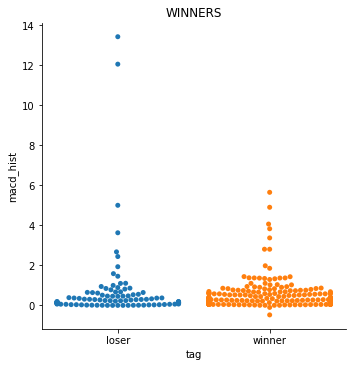

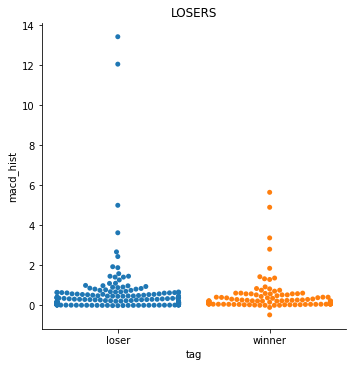

In [545]:
catplot(signal_four_analysis, winners, losers, 'macd_hist')

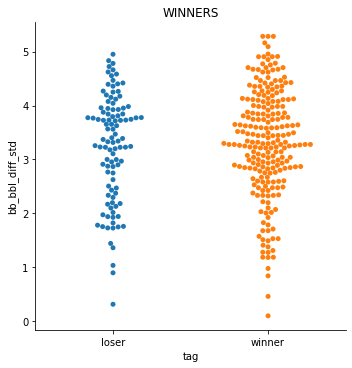

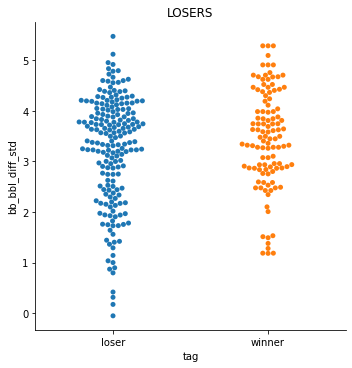

In [542]:
catplot(signal_four_analysis, winners, losers, 'bb_bbl_diff_std')

In [516]:
bb_bbl_test_winners = signal_four_analysis[
                    (signal_four_analysis['symbol'].isin(winners)) 
                  & (signal_four_analysis['tag'].notnull())][['bb_bbl_diff_std', 'tag']]

bb_bbl_test_losers = signal_four_analysis[
                    (signal_four_analysis['symbol'].isin(losers)) 
                  & (signal_four_analysis['tag'].notnull())][['bb_bbl_diff_std', 'tag']]

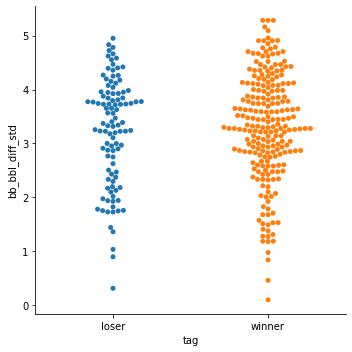

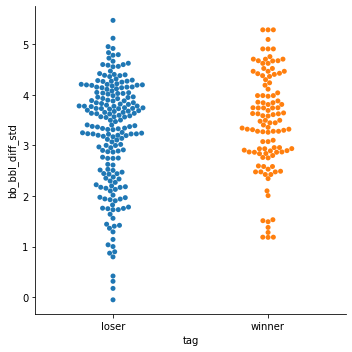

In [517]:
sns.catplot(x="tag", y="bb_bbl_diff_std", kind="swarm", data=bb_bbl_test_losers);

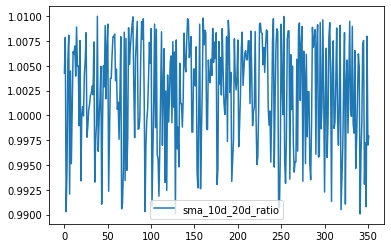

In [476]:
indicators_loss[['sma_10d_20d_ratio']].plot()

In [632]:
(df_2['rsi_bins'] < df_2['rsi_35_max_bin'])
                                        & (df_2['rsi_bins'] > df_2['rsi_bins_shift_2d'])
                                        & (df_2['macd_hist'] >= df_2['macd_hist_1d_shift'])
                                        & (df_2['macd_line_3d_min_coef'] > 0)
                                        & (df_2['macd_line_3d_min_coef'] > df_2['macd_line_5d_min_coef'])
                                        & (df_2['macd_line'] > df_2['macd_signal_line'])
                                        & ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price_x'])

datetime.date(2017, 1, 25)

In [715]:
#clean_data['date_str'] = clean_data['just_date'].astype(str)
#correlation = clean_data[(clean_data['buy_signal?1'] == True) & (clean_data['next_14d_return'] < 1)].corr()
#correlation.to_csv('test DOWN.csv')
multiple_trades = clean_data[(clean_data['buy_signal?1'] == True) & (clean_data['next_14d_return'] < 1)].groupby('just_date').count()['index'].reset_index().sort_values('index', ascending=False).head(20)['just_date']


In [718]:
clean_data[(clean_data['buy_signal?1'] == True) & (clean_data['just_date'].isin(multiple_trades))].corr().to_csv('test4.csv')


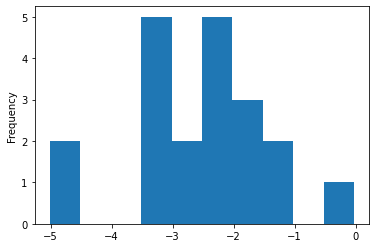

In [720]:
clean_data[(clean_data['buy_signal?1'] == True) & (clean_data['just_date'].isin(multiple_trades))  & (clean_data['next_14d_return'] > 1)]['stationary_sma_200d_zscore_min_shift_3'].plot(kind='hist')


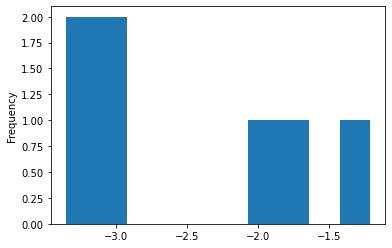

In [721]:
clean_data[(clean_data['buy_signal?1'] == True) & (clean_data['just_date'].isin(multiple_trades))  & (clean_data['next_14d_return'] < 1)]['stationary_sma_200d_zscore_min_shift_3'].plot(kind='hist')


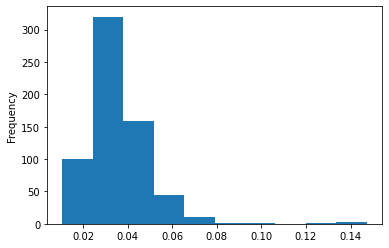

In [700]:
clean_data[(clean_data['buy_signal?1'] == True) & (clean_data['next_14d_return'] < 1)]['sma_20d_50d_ratio_std'].plot(kind='hist')


In [686]:
clean_data[(clean_data['date_str'] == '2018-05-07') & (clean_data['buy_signal?1'] == True)][['symbol', 'next_7d_return', 'sma_20d_100d_ratio_2std_down', 'sma_20d_100d_ratio_std', 'sma_10d_20d_ratio_avg', 'sma_20d_50d_ratio_1std_up_diff']].sort_values('next_7d_return')


,symbol,next_7d_return,sma_20d_100d_ratio_2std_down,sma_20d_100d_ratio_std,sma_10d_20d_ratio_avg,sma_20d_50d_ratio_1std_up_diff
322,VIPS,0.798235,0.565800,0.249241,1.009331,0.198322
322,DHI,0.910647,0.876799,0.092238,1.005533,0.058059
322,TRMB,0.975596,0.898841,0.058677,0.999335,0.057673
322,BX,0.981493,0.939805,0.033849,0.998580,0.050656
322,CRL,0.984529,0.944753,0.041613,1.001301,0.048994
322,WSM,0.986341,0.909488,0.049125,1.000981,0.068573
322,MAS,0.989817,0.933378,0.045212,1.000164,0.060376
322,OESX,1.000000,0.737179,0.079246,0.988992,0.074078
322,JKHY,1.003941,0.969922,0.033629,1.003734,0.033472
322,SHW,1.006523,0.942813,0.045449,1.001849,0.063272


In [450]:
trades['new_buy'] = np.NaN
trades['new_sell'] = np.NaN
trades['new_buy'].mask(
                        (
                            (trades['sma_10d_20d_ratio'] > 0.99)
                            &(trades['sma_10d_20d_ratio'] < 1.01)
                            &(trades['sma_20d_50d_ratio'] > trades['sma_20d_50d_ratio_shift'])
                            &(trades['sma_10d_20d_ratio_shift'] > trades['sma_10d_20d_ratio_shift_2'])
                            &(trades['sma_10d_20d_ratio'] > trades['sma_10d_20d_ratio_shift_2'])
                            &(trades['sma_10d_20d_ratio'] > trades['sma_20d_50d_ratio'])
                            &(trades['sma_20d_50d_ratio_coef_2d'] > 0.001)
                            #&(trades['bb_std'] <= trades['bb_std_avg_100'])
                        )
                        , True, inplace=True)
trades['new_sell'].mask(
                        (
                            (trades['sma_20d_50d_ratio'] < trades['sma_20d_50d_ratio_shift'])
                            &(trades['sma_20d_50d_ratio_shift'] < trades['sma_20d_50d_ratio_shift_2'])
                        )
                        , True, inplace=True)

In [451]:
test_stock = trades[trades['symbol'] == 'AAPL']
test_stock = test_stock.set_index('timestamp')

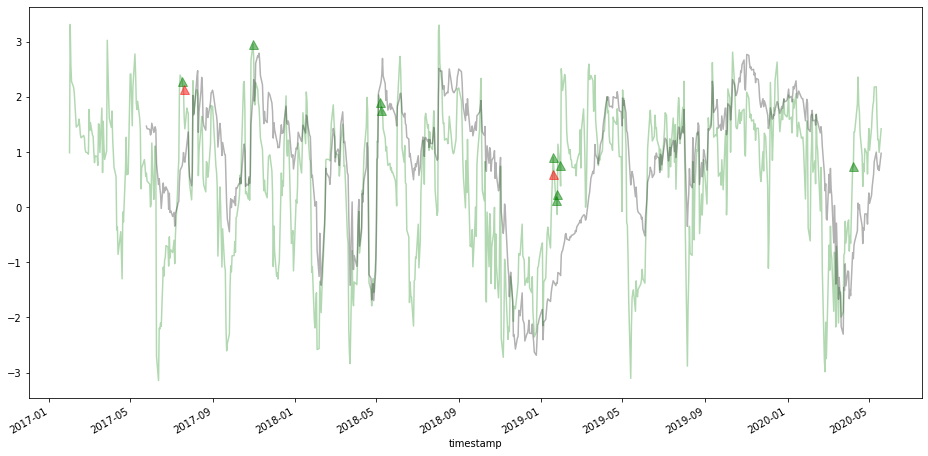

In [452]:
#test_stock['stationary_sma_10d'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock['stationary_sma_20d_zscore'].plot(color='green', alpha=0.3)
test_stock['stationary_sma_100d_zscore'].plot(color='black', alpha=0.3)
#test_stock['stationary_sma_20d'].plot(color='black', alpha=0.3)
#test_stock['stationary_sma_100d_zscore'].plot(color='black', alpha=0.3)
#test_stock['stationary_sma_20d_zscore_min_all'].plot(color='red', alpha=0.3)
#test_stock['stationary_sma_20d_zscore_min_all_shift'].plot(color='blue', alpha=0.3)
#test_stock['stationary_sma_20d_zscore_min_all_shift_2'].plot(color='black', alpha=0.3)
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_7d_return'] > 1)]['stationary_sma_20d_zscore'].plot(figsize=(16,8), linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_7d_return'] < 1)]['stationary_sma_20d_zscore'].plot(figsize=(16,8), linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signals 3')


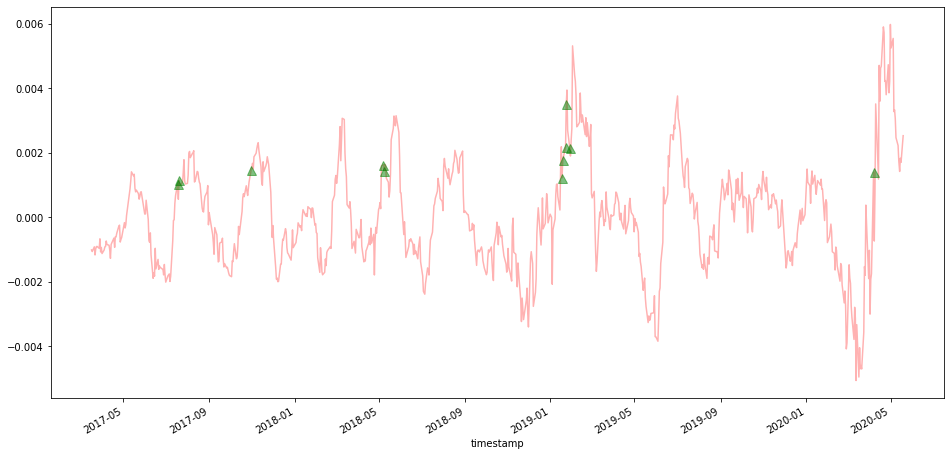

In [453]:
#test_stock['stationary_sma_10d'].plot(figsize=(16,8), color='blue', alpha=0.3)
#test_stock['sma_10d_20d_ratio'].plot(color='red', alpha=0.3)
test_stock['sma_20d_50d_ratio_coef_2d'].plot(color='red', alpha=0.3)
#test_stock['sma_10d_20d_ratio_1std_up'].plot(color='blue', alpha=0.3)
#test_stock['sma_10d_20d_ratio_1std_down'].plot(color='blue', alpha=0.3)
#test_stock['sma_10d_20d_ratio_2std_down'].plot(color='blue', alpha=0.3)
#test_stock['sma_20d_50d_ratio'].plot(color='blue', alpha=0.3)
#test_stock['sma_20d_100d_ratio'].plot(color='black', alpha=0.3)
#test_stock[(test_stock['new_sell'] == True)]['sma_10d_20d_ratio'].plot(figsize=(16,8), linestyle='', marker='^', color='black', alpha = 0.5, markersize = 9, label='Buy Signals 3')

test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] > 1)]['sma_20d_50d_ratio_coef_2d'].plot(figsize=(16,8), linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] < 1)]['sma_20d_50d_ratio_coef_2d'].plot(figsize=(16,8), linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signals 3')


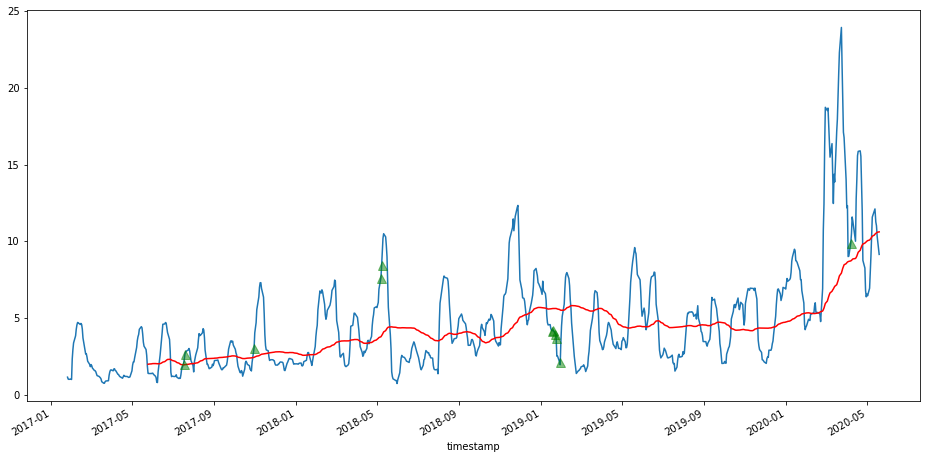

In [454]:
#test_stock['stationary_sma_10d_zscore'].plot(figsize=(16,8), color='blue', alpha=0.3)
#test_stock['bb_bbh'].plot(figsize=(16,8), color='blue', alpha=0.3)
#test_stock['bb_bbl'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock['bb_std'].plot()
test_stock['bb_std_avg_100'].plot(color='red')
#test_stock['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] > 1)]['bb_std'].plot(figsize=(16,8), linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] < 1)]['bb_std'].plot(figsize=(16,8), linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signals 3')
#test_stock[
#            (test_stock['new_sell'] == True)]['momentum_rsi'].plot(figsize=(16,8), linestyle='', marker='o', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')


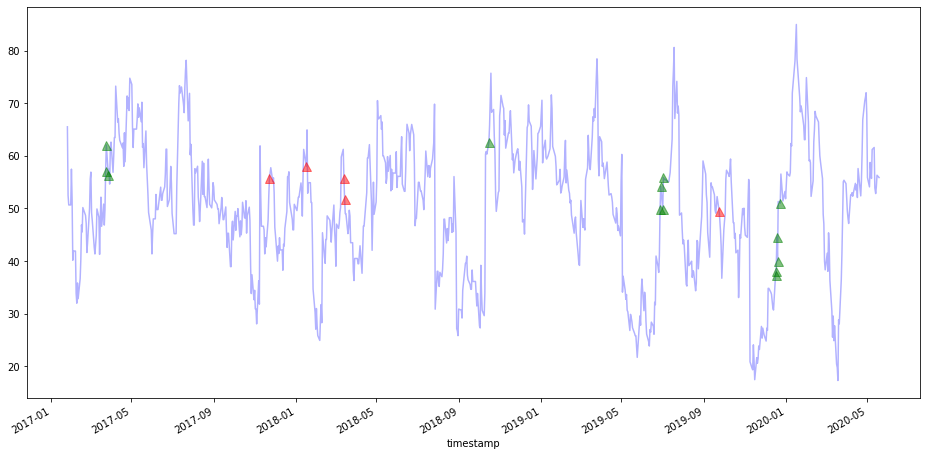

In [423]:
#test_stock['stationary_sma_10d_zscore'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock['momentum_rsi'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] > 1)]['momentum_rsi'].plot(figsize=(16,8), linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] < 1)]['momentum_rsi'].plot(figsize=(16,8), linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signals 3')
#test_stock[
#            (test_stock['new_sell'] == True)]['momentum_rsi'].plot(figsize=(16,8), linestyle='', marker='o', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')


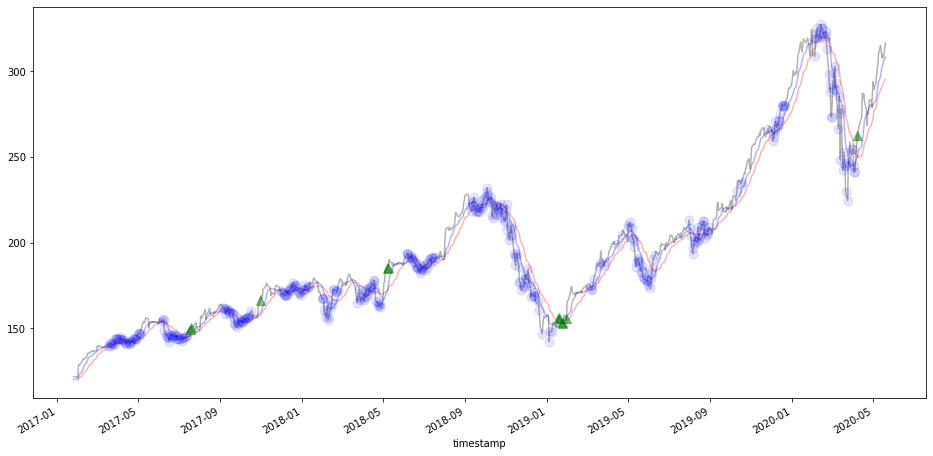

In [593]:
#test_stock['stationary_sma_10d_zscore'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.3)
test_stock['sma_10d'].plot(figsize=(16,8), color='blue', alpha=0.3)
test_stock['close_price_x'].plot(color='black', alpha=0.3)
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] > 1)]['close_price_x'].plot(figsize=(16,8), linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 3')
test_stock[
            (test_stock['new_buy'] == True)
            & (test_stock['next_21d_return'] < 1)]['close_price_x'].plot(figsize=(16,8), linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signals 3')
test_stock[
            (test_stock['new_sell'] == True)]['close_price_x'].plot(figsize=(16,8), linestyle='', marker='o', color='blue', alpha = 0.1, markersize = 9, label='Buy Signals 3')


In [2]:
clean_data = pd.read_feather('../output/all_indicators.feather')

In [3]:
days = 2

In [4]:
min_date = clean_data['timestamp'].max() - timedelta(days=days)
min_date

Timestamp('2020-05-24 15:31:34')

See if there are any buys
### Signal 1

In [5]:
relevant_columns = ['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']

# Create Metrics
metrics = clean_data[(clean_data['buy_signal?1'] == True)][relevant_columns]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol', 'name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol', 'name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2019)]['symbol'])

# Run for the past 5 days
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x', 'low_min_d30']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True) & (clean_data['symbol'].isin(list_of_good))]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

KeyError: 'buy_signal?1'

### Signal 2

In [769]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?2'] == True)][['timestamp', 'symbol', 'name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol', 'year', 'name', 'industry']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol', 'year', 'name', 'industry']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1.05) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return


,symbol,year,name,industry,timestamp,next_7d_return,next_14d_return,next_21d_return


### Signal 3

In [770]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?3'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
834,2020-05-19 19:30:00,RGLD,NaN,NaN,NaN,137.050003
835,2020-05-20 19:45:04,RGLD,NaN,NaN,NaN,136.725006
834,2020-05-19 19:30:00,PETS,NaN,NaN,NaN,32.430000
835,2020-05-20 19:45:15,PETS,NaN,NaN,NaN,33.820000
835,2020-05-20 19:45:04,ZBRA,NaN,NaN,NaN,241.020004
835,2020-05-20 19:45:19,FMC,NaN,NaN,NaN,93.150002
835,2020-05-20 19:43:46,MPWR,NaN,NaN,NaN,209.279999
835,2020-05-20 19:44:56,BEAT,NaN,NaN,NaN,44.419998
835,2020-05-20 19:45:16,WERN,NaN,NaN,NaN,42.889999
834,2020-05-19 19:30:00,AGI,NaN,NaN,NaN,8.460000


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
835,2020-05-20 19:44:57,DIOD,NaN,NaN,NaN
834,2020-05-19 19:30:00,RGLD,NaN,NaN,NaN
835,2020-05-20 19:45:04,RGLD,NaN,NaN,NaN
834,2020-05-19 19:30:00,PETS,NaN,NaN,NaN
835,2020-05-20 19:45:15,PETS,NaN,NaN,NaN
835,2020-05-20 19:45:04,ZBRA,NaN,NaN,NaN
835,2020-05-20 19:45:19,FMC,NaN,NaN,NaN
835,2020-05-20 19:43:46,MPWR,NaN,NaN,NaN
835,2020-05-20 19:45:02,ABMD,NaN,NaN,NaN
835,2020-05-20 19:44:56,BEAT,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
4,ABMD,"Abiomed, Inc.",Healthcare,2017,5,1.054580,1.068575,1.101788
5,ABMD,"Abiomed, Inc.",Healthcare,2018,3,0.917469,1.047174,0.949780
6,ABMD,"Abiomed, Inc.",Healthcare,2019,9,0.983735,0.944349,0.930082
7,ABMD,"Abiomed, Inc.",Healthcare,2020,2,0.922775,0.899155,0.776475
35,AGI,Alamos Gold Inc.,Basic Materials,2017,1,1.038462,1.044379,1.158284
36,AGI,Alamos Gold Inc.,Basic Materials,2018,4,0.946022,0.948174,0.990268
37,AGI,Alamos Gold Inc.,Basic Materials,2019,2,0.919421,0.900896,0.878484
38,AGI,Alamos Gold Inc.,Basic Materials,2020,6,0.918721,1.010877,1.070892
122,BEAT,"BioTelemetry, Inc.",Healthcare,2017,4,1.038056,1.013512,1.028906
123,BEAT,"BioTelemetry, Inc.",Healthcare,2018,7,1.009101,1.095359,1.091998


### Signal 4

In [771]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?4'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return


### Signal 5

In [772]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?5'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return


# Functions to Run Charts

In [6]:
def create_charts_1(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    if field == 'close_price_x':
        snap_df['sma_200d'].plot(color='red', alpha = 0.5, markersize = 7, label='200d')
        snap_df['sma_50d'].plot(color='green', alpha = 0.5, markersize = 7, label='50d')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using ' + field), fontsize=15)
    plt.legend()
    
    plt.show();
              

In [7]:
def create_charts_2(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    snap_df['bb_bbl'].plot(figsize=(16,8), color='red', alpha=0.3)
    snap_df['bb_bbh'].plot(figsize=(16,8), color='red', alpha=0.3)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    # Title
    plt.title((symbol + ' - Buy/Sell Signals using Bollinger Bands'), fontsize=15)
    plt.legend()
    
    plt.show();

In [8]:
def create_charts_3(df, symbol, include_sell=True):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df['macd_signal_line'].plot(figsize=(16,8), color='blue', alpha=0.3, label='MACD Signal Line')
    snap_df['macd_line'].plot(figsize=(16,8), color='red', alpha=0.3, label='MACD Line')
    
    # Buy and Sell Signals 
    snap_df[snap_df['buy_signal?1'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 1')
    snap_df[snap_df['buy_signal?2'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signals 2')
    snap_df[snap_df['buy_signal?3'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signals 3')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='red', markersize = 10, label='Sell Signals')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using MACD'), fontsize=15)
    plt.legend()
    
    plt.show();

## Charts

In [ ]:
# Run Charts
your_symbol = 'AAPL'
create_charts_1(clean_data, your_symbol, include_sell=False)
create_charts_1(clean_data, your_symbol, 'sma_50d_200d_ratio', what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_10d_20d_ratio', what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_20d_50d_ratio', what_to_print=[5])
create_charts_1(clean_data, your_symbol, 'sma_50d_100d_ratio', what_to_print=[5])
create_charts_2(clean_data, your_symbol, what_to_print=[5] )
create_charts_3(clean_data, your_symbol)

## Backtest signals with exit strategies

In [ ]:
def backtest(df, buy_signal_column, support_column, stop_loss, max_holding_days, max_drop, money_per_trade, max_invested):

    # Create buy group1 column and uuid
    df['buy_group_backtest'] = np.NaN
    df['uuid'] = df['fake_index'].astype(str) + df['symbol']

    # A new group will be assigned when
    df['buy_group_backtest'].mask(df[buy_signal_column] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['sell_signal?'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['low_price'] <= df[support_column], df['uuid'], inplace=True)

    # Forward fill groups
    df['buy_group_backtest'] = df['buy_group_backtest'].ffill()

    # Number of days holding 
    df['buy_group_backtest_holdings'] = df.groupby('buy_group_backtest')['timestamp'].rank(method='first')

    # Calculate group cumulative product
    df['buy_group_backtest_cum_return'] = df.groupby('buy_group_backtest').cumprod()['daily_return']
    
    # Create max drop limit
    df['buy_group_backtest_cum_return_shift'] = df['buy_group_backtest_cum_return'].shift(1)
    df['buy_group_backtest_cum_return_diff'] = df['buy_group_backtest_cum_return_shift'] - df['buy_group_backtest_cum_return']
    df['max_drop_limit'] = np.NaN
    df['max_drop_limit'].mask((df['buy_group_backtest_cum_return_diff'] >= max_drop) 
                              & (df['buy_group_backtest_holdings'] != 1), True, inplace=True)    
    
    # Create Loss Threshold
    df['loss_threshold'] = np.NaN
    df['loss_threshold'].mask(df['buy_group_backtest_cum_return'] <= stop_loss, True, inplace=True)

    # Number of days holding threshold
    df['holding_threshold'] = np.NaN
    df['holding_threshold'].mask(df['buy_group_backtest_holdings'] == max_holding_days, True, inplace=True)

    # Total Money Invested
    groups = set(df[df[buy_signal_column] == True]['buy_group_backtest'])
    df['initial_buy'] = np.NaN
    df['initial_buy'].mask(df['buy_group_backtest'].isin(groups), money_per_trade, inplace=True)
    df['today_value_of_investment'] = df['initial_buy'] * df['buy_group_backtest_cum_return']
    
    total_day = df.groupby('just_date').sum()['initial_buy'].reset_index()
    total_day.columns = ['just_date', 'daily_invested']
    df = pd.merge(df, total_day, on ='just_date', how='left')
    
    # Create buy group1 column and uuid
    df['buy_group_backtest'] = np.NaN
    df['uuid'] = df['fake_index'].astype(str) + df['symbol']

    # A new group will be assigned when
    df['buy_group_backtest'].mask((df[buy_signal_column] == True) & (df['daily_invested'] <= max_invested), df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['sell_signal?'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['low_price'] <= df[support_column], df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['holding_threshold'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['loss_threshold'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['max_drop_limit'] == True, df['uuid'], inplace=True)
    
    # Forward fill groups
    df['buy_group_backtest'] = df['buy_group_backtest'].ffill()

    # Number of days holding
    df['buy_group_backtest_holdings'] = df.groupby('buy_group_backtest')['timestamp'].rank(method='first')

    # Calculate group cumulative product
    df['buy_group_backtest_cum_return'] = df.groupby('buy_group_backtest').cumprod()['daily_return']

    # Identify groups
    buy_groups = set(df[(df[buy_signal_column] == True)]['buy_group_backtest'])
    
    # Get last row of every group
    g = df[df['buy_group_backtest'].isin(buy_groups)].groupby('buy_group_backtest')
    returns = pd.concat([g.tail(1)])[['timestamp','symbol', 'industry', 'buy_group_backtest_cum_return', 'buy_group_backtest_holdings']]
    
    return returns, df

In [ ]:
def money_maker(data_frame, signal_name, returns, money_per_trade, print_which='all'):
    
    # Create list of Buy Groups
    buy_groups = set(data_frame[data_frame[signal_name] == True]['buy_group_backtest'])
    plot_me = data_frame[data_frame['buy_group_backtest'].isin(buy_groups)]
    plot_me['money_invested'] = (plot_me['buy_group_backtest_cum_return'] * money_per_trade)
    plot_me['money_return'] = plot_me['money_invested'] - money_per_trade
    
    print(signal_name)
    
    if print_which in ('all', '1'):
        # Money Invested
        plot_me.groupby('timestamp').sum()['money_invested'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Money Invested')
        plt.show();
    
        # Money Gains daily
        plot_me.groupby('timestamp').sum()['money_return'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Gains per Trade', label='Gains per Trade')

    # Cum sum of gains
    returns['money_back'] = (returns['return'] * money_per_trade) - money_per_trade
    gains_df = returns.groupby('date').sum()['money_back'].reset_index()
    gains_df['cum_sum'] = gains_df['money_back'].cumsum()
    gains_df.set_index('date', inplace=True)

    if print_which in ('all', '2'):
        gains_df['cum_sum'].plot(figsize=(14,6), color='green', alpha=0.5, title='Gains - Per Trade and Cum Sum', label = 'Cum Sum of Gains')
        plt.legend()
        plt.show()
    
    # Number of trades
    no_trades = data_frame[(data_frame[signal_name] == True) & (data_frame['buy_group_backtest'].isin(buy_groups))]

    if print_which in ('all', '2'):
        no_trades.groupby('just_date').count()['buy_group_backtest'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Number of Trades per Day', label = 'Daily Trades')

    # Number of trades - Sum sum
    cumsum_trades = data_frame[(data_frame[signal_name] == True) & (data_frame['buy_group_backtest'].isin(buy_groups))]
    cumsum_trades = cumsum_trades.groupby('timestamp').count()['buy_group_backtest'].reset_index()
    cumsum_trades['cum_sum'] = cumsum_trades['buy_group_backtest'].cumsum()
    cumsum_trades.set_index('timestamp', inplace=True)

    if print_which in ('all', '3'):
        cumsum_trades['cum_sum'].plot(figsize=(14,6), color='green', alpha=0.5, title='Number of Trades - Daily and Cum Sum', label='Cum Sum of Trades')
        plt.legend()
        plt.show();
    
    if print_which in ('all', '4'):
        # Number of trades - Sum sum
        gain_trade = gains_df['cum_sum'] / cumsum_trades['cum_sum']
        gain_trade.plot(figsize=(14,6), color='green', alpha=0.5, title='Ratio of Cum Sum Gain / Cum Sum Trades',)
        plt.show();

### Backtest signal 1

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?1', 'low_min_d10', 0.98, 30, 0.05, 100, 5000)
returns.columns = ['date','symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
returns.groupby('days').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?1', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?1', 'low_min_d30', tolerance, 30, max_drop, 100, 5000)
        returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 2

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?2', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('industry').mean()['return'].plot()
returns.groupby('industry').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?2', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?2', 'low_min_d30', tolerance, 30, max_drop)
        returns.columns = ['symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 3

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?3', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('industry').mean()['return'].plot()
returns.groupby('industry').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?3', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?3', 'low_min_d30', tolerance, 30, max_drop)
        returns.columns = ['symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 4

In [ ]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?4', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="days", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('days').mean()['return'].plot()
returns.groupby('days').describe()['return']

In [ ]:
money_maker(data_frame, 'buy_signal?4', returns, 100)

In [ ]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?4', 'low_min_d30', tolerance, 30, max_drop,100,5000)
        returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

In [ ]:
stock_df = clean_data[clean_data['symbol'] == 'AAPL']
stock_df['sma_50d_200d_ratio'].plot(figsize=(16,8), color='blue', alpha=0.3, label='ratio')
stock_df['sma_50d_200d_ratio_avg'].plot(figsize=(16,8), color='red', alpha=0.3, label='avg')
stock_df['sma_50d_200d_ratio_2std_up'].plot(figsize=(16,8), color='green', alpha=0.3, label='std')
stock_df['sma_50d_200d_ratio_2std_down'].plot(figsize=(16,8), color='green', alpha=0.3, label='std')
plt.legend();

In [ ]:
stock_df['my_buy'] = np.NaN
stock_df['my_buy'].mask(
                        (
                            (stock_df['sma_10d_20d_ratio_shift'] < 1)
                            & (stock_df['sma_10d_20d_ratio'] > 1)
                            & (stock_df['sma_20d_50d_ratio_shift'] < stock_df['sma_20d_50d_ratio'])
                        ), True, inplace=True)

stock_df['my_sell'] = np.NaN
stock_df['my_sell'].mask(
                        (
                            (stock_df['sma_20d_50d_ratio_shift'] < stock_df['sma_20d_50d_ratio'])
                        ), True, inplace=True)

stock_df[stock_df['my_buy'] == True]['sma_10d_20d_ratio'].plot(linestyle='', marker='o', color='green', alpha = 0.5, markersize = 7)
stock_df[stock_df['my_sell'] == True]['sma_10d_20d_ratio'].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7)
stock_df['sma_10d_20d_ratio'].plot(figsize=(16,8), color='blue', alpha=0.3, label='ratio')
stock_df['sma_10d_20d_ratio_avg'].plot(figsize=(16,8), color='red', alpha=0.3, label='avg')
stock_df['sma_10d_20d_ratio_2std_up'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_15std_up'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_1std_up'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_2std_down'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_15std_down'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_10d_20d_ratio_1std_down'].plot(figsize=(16,8), color='green', alpha=0.3)
stock_df['sma_20d_50d_ratio'].plot(figsize=(16,8), color='black', alpha=0.3, label='ratio')
plt.legend();

In [ ]:
#(stock_df['sma_10d_20d_ratio'] -1).plot(figsize=(16,8), color='white', alpha=0.3, label='ratio')
#stock_df['sma_10d_20d_ratio_avg'].plot(figsize=(16,8), color='red', alpha=0.3, label='avg')
stock_df['sma_10d_20d_ratio_175std_up_diff'].plot(figsize=(16,8), color='green', alpha=0.3, label='std')
stock_df['sma_10d_20d_ratio_175std_down_diff'].plot(figsize=(16,8), color='red', alpha=0.3, label='std')
plt.legend();

In [ ]:
fig = plt.figure()
stock_df['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.3, label='ratio')
for x, y, t, a, b in [(10,20,'green', 20,50), (20,50,'black', 50, 100), (50,100,'red', 100, 200), (100,200,'orange', 100,200), (50,200,'blue', 50,200)]:
#for x, y in [(50,200)]:
    
    #plt.subplot(t)
    title = str(x) + ' - ' + str(y)
    stock_df['my_buy'] = np.NaN
    stock_df['my_buy'].mask((
                            (stock_df[f'sma_{x}d_{y}d_ratio_shift'] < 1)
                            & (stock_df[f'sma_{x}d_{y}d_ratio'] > 1)
                            & (stock_df[f'sma_{a}d_{b}d_ratio_shift'] < stock_df[f'sma_{a}d_{b}d_ratio'])
                        ), True, inplace=True)
    stock_df[stock_df['my_buy'] == True]['close_price_x'].plot(linestyle='', marker='o', color=t, alpha = 0.5, markersize = 10, label=title)
    
plt.legend();

In [ ]:


returns1, data_frame1 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?1', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns1.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame1, 'buy_signal?1', returns1, 100, '4')

returns2, data_frame2 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?2', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns2.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame2, 'buy_signal?2', returns2, 100, '4')

returns3, data_frame3 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?3', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns3.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame3, 'buy_signal?3', returns3, 100, '4')

returns4, data_frame4 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?4', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns4.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame4, 'buy_signal?4', returns4, 100, '4')

In [ ]:
money_maker(data_frame1, 'buy_signal?1', returns1, 100, '2')
money_maker(data_frame2, 'buy_signal?2', returns2, 100, '2')
money_maker(data_frame3, 'buy_signal?3', returns3, 100, '2')
money_maker(data_frame4, 'buy_signal?4', returns4, 100, '2')

In [ ]:
clean_data.head()

In [ ]:
def compare_years(max_drop_list, tolerance_list, years_list, signal_name, your_df):
    
    for idxx, year in enumerate(years_list):
        print(year)
        heatmap = []
        for idx, tolerance in enumerate(tolerance_list):
            for max_drop in max_drop_list: 
                returns = backtest(your_df[your_df['year'] == year], signal_name, 'low_min_d30', tolerance, 30, max_drop)
                returns.columns = ['symbol', 'industry', 'return', 'days']
                heatmap.append([tolerance, max_drop, returns['return'].mean()])
        to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
        pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
        sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
    
        plt.show()

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?1',
              your_df=clean_data)

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?2',
              your_df=clean_data)

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?3',
              your_df=clean_data)

In [ ]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?4',
              your_df=clean_data)

In [ ]:
to_plot = clean_data[(clean_data['buy_signal?1'] == True)]
to_plot['next_21d_return'].mean()

In [ ]:
to_plot['macd_hist_3d_min_coef'].plot.hist()

In [ ]:
test = clean_data[clean_data['symbol'] == 'AAPL']
test['buy_reno'] = np.NaN
test['buy_reno'].mask(
                                        (
                                            #(test['stationary_sma_10d_zscore_shift_2'] <= test['stationary_sma_10d_zscore_shift'])
                                            #(test['stationary_sma_10d_zscore'] > test['stationary_sma_10d_zscore_shift'])
                                            #(test['stationary_sma_10d_zscore'] < test['stationary_sma_10d_zscore_max'])
                                            (test['stationary_sma_10d_zscore_shift'] == test['stationary_sma_10d_zscore_min'])
                                            #(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
                                            #& (df_2['stationary_sma_10d_zscore_shift_2'] <= (0.8 * df_2['stationary_sma_10d_zscore_min_all_shift_2']))
                                            & (test['moving_2d_return'] > 1)
                                            #& (test['rsi_bins'] < test['rsi_175_max_bin'])
                                            #& (test['rsi_bins'] > test['rsi_175_min_bin'])
                                            #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
                                        )
                                        , True, inplace=True)

test['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.5)
test[test['buy_reno'] == True]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
#test['stationary_sma_10d_zscore'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['stationary_sma_10d_zscore_shift'].plot(figsize=(16,8), color='red', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)

In [ ]:
print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_21d_return'] > 1)].count()['index'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
   # & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_21d_return'] < 1)].count()['index'])


In [ ]:
test['macd_line'].plot(figsize=(16,8), color='blue', alpha=0.5)

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] > 1)]['macd_line'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
   # & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] < 1)]['macd_line'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [ ]:
test['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['sma_10d'].plot(figsize=(16,8), color='green', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)
#test[(test['low_min_d10'] > test['low_min_d10_shift1_10']) 
    #& (test['low_min_d10_shift1_10'] > test['low_min_d10_shift2_20'])
    #& (test['stationary_sma_100d_zscore'] <= (0.8 * test['stationary_sma_100d_zscore_min_all']))
    #& (test['sma_10d'] > test['sma_20d']) ]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    #& (test['sma_10d_shift'] < test['sma_20d_shift'])

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_35_min_bin_low'] < test['rsi_bins'])
    & (test['rsi_bins'] < 7)
    & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] > 1)]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_35_min_bin_low'] < test['rsi_bins'])
    & (test['rsi_bins'] < 7)
    & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] < 1)]['close_price_x'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [ ]:
test['rsi_bins'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['sma_10d'].plot(figsize=(16,8), color='green', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)
#test[(test['low_min_d10'] > test['low_min_d10_shift1_10']) 
    #& (test['low_min_d10_shift1_10'] > test['low_min_d10_shift2_20'])
    #& (test['stationary_sma_100d_zscore'] <= (0.8 * test['stationary_sma_100d_zscore_min_all']))
    #& (test['sma_10d'] > test['sma_20d']) ]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    #& (test['sma_10d_shift'] < test['sma_20d_shift'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    & (test['next_14d_return'] > 1)].count()['index'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] < 1)].count()['index'])

In [ ]:
test['sma_10d_coef'].plot(figsize=(16,8), color='blue', alpha=0.5)
test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] > 1)]['sma_10d_coef'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] < 1)]['sma_10d_coef'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [ ]:
clean_data = 0
df_1 = 0
test = 0
data_frame = 0
data_frame1 = 0
data_frame2 = 0
data_frame3 = 0
data_frame4 = 0

In [ ]:


# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)